Diagnóstico del cáncer de seno usando redes neuronales
===

* *60 min* | Ultima modificación: Noviembre 6, 2020.

**Bibliografía.**
* Machine Learning with R. Brett Lantz, Packt Publishing, Second Edition, 2015.

## Descripción del problema

Se desea determinar si una masa mamaria es un tumor benigno o maligno, a partir de las medidas obtenidas de imágenes digitalizadas de la aspiración con una aguja fina. Los valores representan las características de los núcleos celulares presentes en la imagen digital. La muestra de 569 ejemplos de resultados de las biopsias. Cada registro contiene 32 variables, las cuales corresponden a tres medidas (media, desviación estándar, peor caso) de diez características diferentes (radius, texture, ...).

* Identification number
* Cancer diagnosis ("M" para maligno y "B" para benigno)
* Radius
* Texture
* Perimeter
* Area
* Smoothness
* Compactness
* Concavity
* Concave points
* Symmetry
* Fractal dimension

En términos de los datos, se desea pronosticar si una masa es benigna o maligna (clase B o M) a partir de las 30 variables.

Fuente de los datos: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

El problema en términos matemáticos se define de la siguiente forma. 

* Se tienen $M$ ejemplos (las 569 observaciones del problema analizado).  
* Cada ejemplo esta definido por un conjunto de variables ($x_1$, $x_2$, ..., $x_N$); es decir, las 30 columnas de datos.
* Cada ejemplo pertenece a una clase y hay $P$ clases diferentes; en el caso analizado sólo hay dos clases: benigno o maligno. 
* Para un nuevo caso (tumor) y con base en las 30 mediciones realizadas (variables), se desea pronosticar a que clase pertenece (maligno o benigno). 

## Preparación y carga de datos

In [1]:
!wget https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/wisc_bc_data.csv

--2020-11-02 02:01:13--  https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/wisc_bc_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125773 (123K) [text/plain]
Saving to: ‘wisc_bc_data.csv’

wisc_bc_data.csv    100%[===================>] 122.83K  --.-KB/s    in 0.1s    

2020-11-02 02:01:14 (1.07 MB/s) - ‘wisc_bc_data.csv’ saved [125773/125773]



In [2]:
##
## Mueve el archivo de datos al hdfs
##
!hdfs dfs -copyFromLocal wisc_bc_data.csv /tmp/wisc_bc_data.csv

## Spark 

In [3]:
##
## Carga de las librerías de Spark
##
import findspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

findspark.init()

APP_NAME = "spark-app"

conf = SparkConf().setAppName(APP_NAME)
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

## Carga de datos

In [4]:
##
## Lectura del archivo.
##
spark_df = spark.read.load(
    "/tmp/wisc_bc_data.csv", format="csv", sep=",", inferSchema="true", header="true"
)


##
## Tipos de datos de los campos del DataFrame
##
spark_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave_points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)
 |-- radius_se: double (nullable = true)
 |-- texture_se: double (nullable = true)
 |-- perimeter_se: double (nullable = true)
 |-- area_se: double (nullable = true)
 |-- smoothness_se: double (nullable = true)
 |-- compactness_se: double (nullable = true)
 |-- concavity_se: double (nullable = true)
 |-- concave_points_se: double (nullable = true)
 |-- symmetry_se: double (nullable = true)
 |-- fractal_dimension_se: double (nullable = true)
 |-- radi

In [5]:
##
## Contenido del archivo
##
spark_df.show()

+--------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|      id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave_points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave_points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave_points_worst|symmetry_worst|fractal_dimension_worst|
+--------+---------+-----------+------------+---

In [6]:
##
## Número de registros cargados
##
spark_df.count()

569

## Análisis exploratorio

<AxesSubplot:xlabel='diagnosis'>

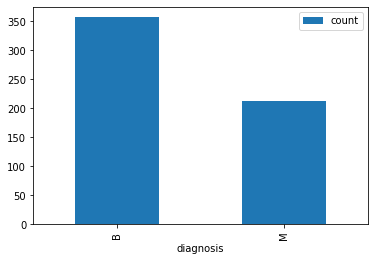

In [7]:
##
## Cantidad de casos para cada diagnóstico.
##
spark_df.groupby("diagnosis").count().toPandas().set_index("diagnosis").plot.bar()

In [8]:
##
## Cantidad de casos para cada diagnóstico.
##
spark_df.groupby("diagnosis").count().toPandas()

diagnosis  count
0         B    357
1         M    212

In [9]:
##
## Probabilidades
##
pdf = spark_df.groupby("diagnosis").count().toPandas().set_index("diagnosis")
round(100 * pdf["count"] / pdf["count"].sum(), 1)

diagnosis
B    62.7
M    37.3
Name: count, dtype: float64

## Preparación de los datos

In [10]:
##
## Columnas que contiene el dataframe
##
inputCols = [a for a, _ in spark_df.dtypes]
inputCols.remove("diagnosis")
inputCols.remove("id")
len(inputCols)

30

In [11]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(
    inputCols=inputCols,
    outputCol="features",
)

spark_df = vectorAssembler.transform(spark_df)

spark_df.select("features").show()

+--------------------+
|            features|
+--------------------+
|[17.99,10.38,122....|
|[20.57,17.77,132....|
|[19.69,21.25,130....|
|[11.42,20.38,77.5...|
|[20.29,14.34,135....|
|[12.45,15.7,82.57...|
|[18.25,19.98,119....|
|[13.71,20.83,90.2...|
|[13.0,21.82,87.5,...|
|[12.46,24.04,83.9...|
|[16.02,23.24,102....|
|[15.78,17.89,103....|
|[19.17,24.8,132.4...|
|[15.85,23.95,103....|
|[13.73,22.61,93.6...|
|[14.54,27.54,96.7...|
|[14.68,20.13,94.7...|
|[16.13,20.68,108....|
|[19.81,22.15,130....|
|[13.54,14.36,87.4...|
+--------------------+
only showing top 20 rows



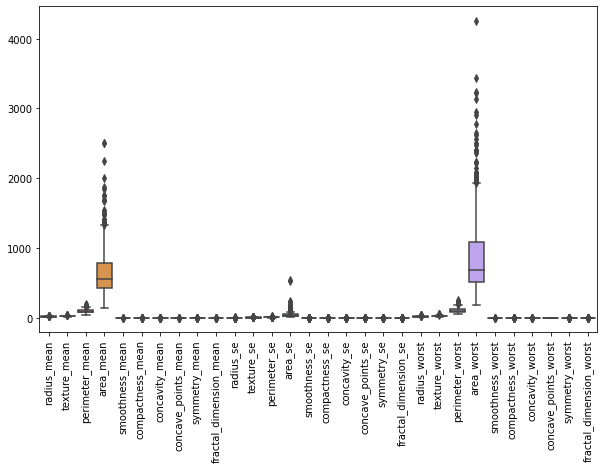

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

##
## Los rangos de las variables numéricas son
## bastantes diferentes
##
plt.figure(figsize=(10, 6))
pdf = spark_df.toPandas()
pdf.pop('id')
sns.boxplot(data=pdf)
plt.xticks(rotation=90);

In [13]:
##
## Escalamiento
##
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(spark_df)

spark_df = scalerModel.transform(spark_df)

spark_df.select("scaledFeatures").show()

+--------------------+
|      scaledFeatures|
+--------------------+
|[0.52103743669837...|
|[0.64314449335037...|
|[0.60149557480240...|
|[0.21009039708457...|
|[0.62989256472147...|
|[0.25883856311231...|
|[0.53334279899663...|
|[0.31847224194235...|
|[0.28486913720478...|
|[0.25931184627762...|
|[0.42780065313076...|
|[0.41644185716314...|
|[0.57688485020587...|
|[0.41975483932036...|
|[0.31941880827298...|
|[0.35775474466373...|
|[0.36438070897818...|
|[0.43300676794926...|
|[0.60717497278621...|
|[0.31042642813195...|
+--------------------+
only showing top 20 rows



In [14]:
##
## Reemplaza {M,B} por {0,1}
##
from pyspark.sql.functions import when

spark_df = spark_df.withColumn('diagnosis', when(spark_df['diagnosis'] == 'M', 0).otherwise(spark_df['diagnosis']))
spark_df = spark_df.withColumn('diagnosis', when(spark_df['diagnosis'] == 'B', 1).otherwise(spark_df['diagnosis']))

spark_df.groupby("diagnosis").count().toPandas()

diagnosis  count
0         0    212
1         1    357

In [15]:
##
## Transforma la columna diagnosis de string a entero
##
from pyspark.sql.types import IntegerType

spark_df = spark_df.withColumn("diagnosis", spark_df["diagnosis"].cast(IntegerType()))

## Conjuntos de datos para entrenamiento y prueba

In [16]:
##
## Se usa el 80% de los datos para entrenamiento
## y el 20% restante para prueba
##
(train_df, test_df) = spark_df.randomSplit([0.8, 0.2])

## Entrenamiento del modelo

In [17]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

##
## Creación del modelo
##
trainer = MultilayerPerceptronClassifier(
    featuresCol="scaledFeatures",
    labelCol="diagnosis",
    predictionCol="prediction_MLP",
    probabilityCol="probability_MLP",
    rawPredictionCol="rawPrediction_MLP",
    maxIter=100,
    layers=[30, 1, 2], # 30 inputs, 1 neuron, 2 clases
    seed=1234,
)

##
## Entrenamiento
##
model = trainer.fit(train_df)

##
## Pronóstico
##
train_df = model.transform(train_df)
test_df = model.transform(test_df)

## Desempeño del modelo

In [18]:
import pyspark.sql.functions as F
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


def print_stats(dataframes, prediction_col):

    evaluator = MulticlassClassificationEvaluator(
        labelCol="diagnosis",
        predictionCol=prediction_col,
        metricName="accuracy",
    )

    print("Train Error = %g " % (1.0 - evaluator.evaluate(train_df)))
    print("Test Error = %g " % (1.0 - evaluator.evaluate(test_df)))
    print()
    
    for df in dataframes:

        predictionAndLabels = df.select([prediction_col, "diagnosis"])
        predictionAndLabels = predictionAndLabels.withColumn(
            prediction_col, F.col(prediction_col).cast(FloatType())
        )
        predictionAndLabels = predictionAndLabels.withColumn(
            "diagnosis", F.col("diagnosis").cast(FloatType())
        )

        metrics = MulticlassMetrics(predictionAndLabels.rdd.map(tuple))

        print(metrics.confusionMatrix().toArray())
        print()
        
print_stats(dataframes=[train_df, test_df], prediction_col = 'prediction_MLP')

Train Error = 0 
Test Error = 0.0645161 

[[167.   0.]
 [  0. 278.]]

[[40.  5.]
 [ 3. 76.]]



## Linear Support Vector Classifier

In [19]:
from pyspark.ml.classification import LinearSVC

##
## Creación del modelo
##
trainer = LinearSVC(
    featuresCol="scaledFeatures",
    labelCol="diagnosis",
    predictionCol="prediction_SVC",
    rawPredictionCol="rawPrediction_SVC",
    maxIter=100,
    regParam=0.0,
)

##
## Entrenamiento
##
model = trainer.fit(train_df)

##
## Pronóstico
##
train_df = model.transform(train_df)
test_df = model.transform(test_df)

print_stats(dataframes=[train_df, test_df], prediction_col = 'prediction_SVC')

Train Error = 0.0179775 
Test Error = 0.0403226 

[[161.   6.]
 [  2. 276.]]

[[42.  3.]
 [ 2. 77.]]



**Ejercicio.---** Cuál es el número óptimo de neuronas para una capa oculta. 